In [1]:
# Getting all the imports done

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Using TensorFlow backend.


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id = '1AeW5C0r-mpV_-TD28V8IWx36wDZ9iMgR'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('database.sqlite')

In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#con = sqlite3.connect('https://drive.google.com/open?id=1AeW5C0r-mpV_-TD28V8IWx36wDZ9iMgR') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.reset_index(drop=True, inplace=True)

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

(87773, 10)


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split())
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:36<00:00, 2423.04it/s]


In [13]:
final['Cleaned_Text']=preprocessed_reviews
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
0,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,i bought a few of these after my apartment was...
1,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,this was a really good idea and the final prod...
2,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,i just received my shipment and could hardly w...
3,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",nothing against the product but it does bother...
4,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,i love this stuff it is sugar free so it does ...


In [0]:
final_review = final[['Cleaned_Text','Score']]
X = final_review.drop(['Score'],axis=1)
Y = final_review['Score']

In [15]:
# Train_Test Splitting
from sklearn.model_selection import train_test_split

X_1, X_test, Y_1, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)
print(X_1.shape,Y_1.shape)

(70218, 1) (70218,)


In [0]:
text1 = X_1['Cleaned_Text'][1]

In [17]:
print(text1)

this was a really good idea and the final product is outstanding i use the decals on my car window and everybody asks where i bought the decals i made two thumbs up


In [0]:
#https://www.kdnuggets.com/2019/11/create-vocabulary-nlp-tasks-python.html

class Vocabulary:
    
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.num_words = 3
        self.num_sentences = 0
        self.longest_sentence = 0

    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        for word in sentence.split(' '):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

In [19]:
voc = Vocabulary('test')
print(voc)

In [0]:
for sent in X_1['Cleaned_Text']:
  voc.add_sentence(sent)

In [21]:
print('Token 4 corresponds to word:', voc.to_word(4))
print('Token "bought" corresponds to index:', voc.to_index('bought'))

Token 4 corresponds to word: bought
Token "bought" corresponds to index: 4


In [22]:
print("Total number of words in the Vocabulary : ",voc.num_words)

Total number of words in the Vocabulary :  49250


In [23]:
print("Printing the first 10 words of the vocabulary : ")

i = 0
for word in range(3,voc.num_words):
    print(voc.to_word(word))
    i +=1
    if(i>10):
        break

Printing the first 10 words of the vocabulary : 
i
bought
a
few
of
these
after
my
apartment
was
infested


In [24]:
print("Printing the dictionary containing words and their corrsponding frequencies :\n")
print(voc.word2count)

Printing the dictionary containing words and their corrsponding frequencies :

{'i': 200159, 'bought': 6044, 'a': 145383, 'few': 4506, 'of': 95325, 'these': 29082, 'after': 8410, 'my': 54294, 'apartment': 35, 'was': 39200, 'infested': 14, 'with': 42919, 'fruit': 2683, 'flies': 68, 'only': 12062, 'hours': 965, 'the': 224936, 'trap': 93, 'had': 15496, 'attracted': 29, 'many': 5144, 'and': 157141, 'within': 849, 'days': 2272, 'they': 38112, 'were': 10040, 'practically': 119, 'gone': 932, 'this': 81854, 'may': 2904, 'not': 74135, 'be': 22479, 'long': 3668, 'term': 135, 'solution': 221, 'but': 43297, 'if': 20072, 'are': 44895, 'driving': 93, 'you': 45636, 'crazy': 670, 'consider': 552, 'buying': 3544, 'one': 21271, 'caution': 136, 'surface': 88, 'is': 126887, 'very': 20713, 'sticky': 375, 'so': 30499, 'try': 8264, 'to': 121829, 'avoid': 588, 'touching': 22, 'it': 128079, 'really': 12181, 'good': 24586, 'idea': 979, 'final': 138, 'product': 17594, 'outstanding': 288, 'use': 9905, 'decals': 4

In [25]:
word2count_sorted_keys = sorted(voc.word2count, key=voc.word2count.get, reverse=True)[:5000]

print("Printing the top 5000 words of the vocabulary : \n ")
i = 0
for r in word2count_sorted_keys:
    print(r, voc.word2count[r])
    i +=1
    if(i>10):
        break

Printing the top 5000 words of the vocabulary : 
 
the 224936
i 200159
and 157141
a 145383
it 128079
is 126887
to 121829
of 95325
this 81854
not 74135
for 66001


In [26]:
print(type(word2count_sorted_keys))

<class 'list'>


In [0]:
rank = list(range(1,5001))

In [28]:
print("Printing the dictionary created with top words in descending order and their corresponding rank : \n")
rank_dict = dict(zip(word2count_sorted_keys, rank))
print(rank_dict)

Printing the dictionary created with top words in descending order and their corresponding rank : 

{'the': 1, 'i': 2, 'and': 3, 'a': 4, 'it': 5, 'is': 6, 'to': 7, 'of': 8, 'this': 9, 'not': 10, 'for': 11, 'in': 12, 'my': 13, 'that': 14, 'have': 15, 'you': 16, 'are': 17, 'but': 18, 'with': 19, 'was': 20, 'they': 21, 'as': 22, 'on': 23, 'like': 24, 'so': 25, 'these': 26, 'them': 27, 'good': 28, 'be': 29, 'or': 30, 'at': 31, 'can': 32, 'one': 33, 'will': 34, 'great': 35, 'very': 36, 'taste': 37, 'just': 38, 'if': 39, 'do': 40, 'all': 41, 'would': 42, 'we': 43, 'from': 44, 'product': 45, 'flavor': 46, 'coffee': 47, 'am': 48, 'when': 49, 'tea': 50, 'has': 51, 'more': 52, 'had': 53, 'love': 54, 'me': 55, 'food': 56, 'than': 57, 'out': 58, 'no': 59, 'other': 60, 'get': 61, 'some': 62, 'up': 63, 'about': 64, 'really': 65, 'only': 66, 'too': 67, 'amazon': 68, 'much': 69, 'an': 70, 'there': 71, 'your': 72, 'also': 73, 'time': 74, 'were': 75, 'because': 76, 'little': 77, 'use': 78, 'best': 79, '

In [29]:
# Replacing the words in Train dataset with their rank

list_1 = []
for sent in tqdm(X_1['Cleaned_Text']):
    list_2 = []
    for word in sent.split():
        if word in rank_dict:
            rank = rank_dict.get(word)
            list_2.extend([rank])
    list_1.append(list_2)

100%|██████████| 70218/70218 [00:02<00:00, 26320.56it/s]


In [30]:
print(list_1[9])

[49, 6, 143, 1101, 195, 1229, 4124, 12, 1, 3442, 512, 31, 252, 146, 42, 61, 253, 1, 252, 135, 157, 184, 1, 131, 239, 119, 319, 14, 1577, 16, 19, 1, 116, 1087, 3586, 16, 154, 135, 2812, 68, 1595, 9, 131, 700, 1276, 319, 3, 32, 61, 183, 7, 739, 184, 1017, 6, 66, 1058, 64, 6, 1, 313, 880, 46, 764, 477, 313, 880, 18, 9, 46, 6, 25, 1112, 678, 7, 98, 5, 255, 25, 22, 10, 7, 3690, 1, 2227, 547, 506, 451, 3, 1046, 150, 153]


In [31]:
X_1['Word_Rank'] = list_1
print(X_1.head(5))

                                        Cleaned_Text                                          Word_Rank
0  i bought a few of these after my apartment was...  [2, 120, 4, 159, 8, 26, 95, 13, 20, 19, 288, 3...
1  this was a really good idea and the final prod...  [9, 20, 4, 65, 28, 627, 3, 1, 2605, 45, 6, 157...
2  i just received my shipment and could hardly w...  [2, 38, 322, 13, 819, 3, 107, 1645, 724, 7, 99...
3  nothing against the product but it does bother...  [355, 1758, 1, 45, 18, 5, 96, 1575, 55, 14, 71...
4  i love this stuff it is sugar free so it does ...  [2, 54, 9, 164, 5, 6, 106, 119, 25, 5, 96, 10,...


In [32]:
# Replacing the words in Test dataset with their rank

list_test1 = []
for sent in tqdm(X_test['Cleaned_Text']):
    list_test2 = []
    for word in sent.split():
        if word in rank_dict:
            rank = rank_dict.get(word)
            list_test2.extend([rank])
    list_test1.append(list_test2)

100%|██████████| 17555/17555 [00:00<00:00, 20010.52it/s]


In [33]:
print(list_test1[1])

[2, 951, 2740, 7, 9, 2079, 167, 560, 1, 150, 8, 911, 3, 209, 176, 87, 100, 3, 2, 15, 716, 777, 1, 562, 3, 362, 3053, 22, 2, 48, 3372, 176, 333, 13, 305, 41, 343, 8, 27, 933, 41, 8, 13, 305, 15, 1062, 454, 1, 4875, 218, 64, 3487, 180, 1776, 1, 133, 2720, 454, 1434, 18, 100, 1, 266, 180, 3, 266, 180, 1636, 239, 218, 15, 1564, 4376, 2, 1556, 11, 3, 114, 355, 2, 48, 10, 200, 80, 7, 125, 2, 34, 1200, 9, 49, 2, 61, 7, 1, 1887]


In [0]:
X_test['Word_Rank'] = list_test1

In [35]:
print(X_test.head(5))

                                            Cleaned_Text                                          Word_Rank
80551  my wife and i love to travel bicycle in summer...  [13, 525, 3, 2, 54, 7, 1348, 12, 935, 74, 12, ...
80552  i switched exclusively to this purina brand al...  [2, 951, 2740, 7, 9, 2079, 167, 560, 1, 150, 8...
80554  my border collie mix month old puppy loved the...  [13, 3527, 3671, 136, 442, 180, 768, 302, 26, ...
80555  i had to be taken to the er in an ambulance ea...  [2, 53, 7, 29, 1445, 7, 1, 12, 70, 2083, 1, 13...
80556  bad product gave to my labs beagle times over ...  [206, 45, 375, 7, 13, 3860, 3052, 378, 123, 32...


In [36]:
# truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(X_1['Word_Rank'], maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test['Word_Rank'], maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(70218, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [37]:
print(X_test[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [0]:
from keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import roc_auc_score
import numpy as np

In [0]:

class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

In [0]:
aucCal = roc_callback(training_data=(X_train, Y_1),validation_data=(X_test, Y_test))
earlyStop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min')

In [0]:
import tensorflow as tf
from keras import backend as K

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

**MODEL 1 :**

In [0]:
# create the model 1
top_words = 5000
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(150))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',auc])
print(model.summary())






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               109800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 269,983
Trainable params: 269,983
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history1_lstm_model1 = model.fit(X_train, Y_1, nb_epoch=15, batch_size=64, validation_data=(X_test, Y_test), callbacks=[aucCal, earlyStop] )
# Final evaluation of the model
scores1 = model.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores1[1]*100))
print(scores1)
print("Loss : ", scores1[0])



Train on 70218 samples, validate on 17555 samples
Epoch 1/15
70218/70218 [==============================] - 1338s 19ms/step - loss: 0.2665 - acc: 0.8946 - auc: 0.8192 - val_loss: 0.2182 - val_acc: 0.9181 - val_auc: 0.9033
roc-auc: 0.9563 - roc-auc_val: 0.9428                                                                                                    
Epoch 2/15
70218/70218 [==============================] - 1339s 19ms/step - loss: 0.1890 - acc: 0.9273 - auc: 0.9204 - val_loss: 0.2129 - val_acc: 0.9216 - val_auc: 0.9293
roc-auc: 0.968 - roc-auc_val: 0.9471                                                                                                    
Epoch 3/15
70218/70218 [==============================] - 1353s 19ms/step - loss: 0.1685 - acc: 0.9356 - auc: 0.9358 - val_loss: 0.2184 - val_acc: 0.9187 - val_auc: 0.9400
roc-auc: 0.9743 - roc-auc_val: 0.9483                                                                                                    
Epoch 4/15
70218/70

NameError: ignored

In [0]:
print(history1_lstm_model1.history.keys())
print(scores1)
print('Loss : ', scores1[0])

dict_keys(['val_loss', 'val_acc', 'val_auc', 'loss', 'acc', 'auc'])
[0.1982698681165616, 0.9269723725434349, 0.9589489849161742]
Loss :  0.1982698681165616


In [0]:
print("Test AUC for Model 1 with 1 Layer : ", scores1[2])

Test AUC for Model 1 with 1 Layer :  0.9589489849161742


In [0]:
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x , ty, vy, ax, colors=['b']):
 ax.plot(x , ty , 'b' , label='Train Loss')
 ax.plot(x , vy , 'g' , label='Validation Loss')
 plt.legend()
 plt.grid()
 fig.canvas.draw()

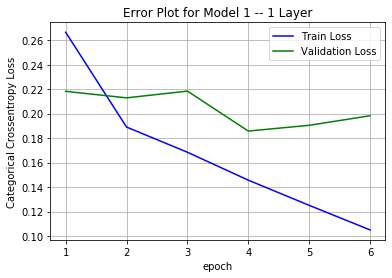

In [0]:
# Plotting the Loss Vs Epoch graph
fig, ax = plt.subplots(1,1)
x = list(range(1,6+1))
vy = history1_lstm_model1.history['val_loss']
ty = history1_lstm_model1.history['loss']
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss'); ax.set_title('Error Plot for Model 1 -- 1 Layer')
plt_dynamic(x,ty,vy,ax)

**MODEL 2 :**

In [49]:
top_words = 5000
embedding_vector_length = 32
model_layer2 = Sequential()
model_layer2.add(Embedding(top_words+1, embedding_vector_length, input_length=max_review_length))
model_layer2.add(LSTM(200, return_sequences=True))
model_layer2.add(LSTM(150))
model_layer2.add(Dropout(0.5))
model_layer2.add(Dense(1, activation='sigmoid'))
model_layer2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',auc])
print(model_layer2.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_7 (LSTM)                (None, 600, 200)          186400    
_________________________________________________________________
lstm_8 (LSTM)                (None, 150)               210600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total params: 557,183
Trainable params: 557,183
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
history3_lstm_model2 = model_layer2.fit(X_train, Y_1, nb_epoch=7, batch_size=64, validation_data=(X_test, Y_test), callbacks=[aucCal, earlyStop] )
# Final evaluation of the model
scores3 = model_layer2.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores3[1]*100))
print(scores3)
print("Loss : ", scores3[0])

Train on 70218 samples, validate on 17555 samples
Epoch 1/7
70218/70218 [==============================] - 2059s 29ms/step - loss: 0.3640 - acc: 0.8625 - auc: 0.6649 - val_loss: 0.2343 - val_acc: 0.9034 - val_auc: 0.8144
roc-auc: 0.9437 - roc-auc_val: 0.932                                                                                                    
Epoch 2/7
70218/70218 [==============================] - 2164s 31ms/step - loss: 0.2460 - acc: 0.9034 - auc: 0.8481 - val_loss: 0.2024 - val_acc: 0.9191 - val_auc: 0.8782
roc-auc: 0.9635 - roc-auc_val: 0.9489                                                                                                    
Epoch 3/7
70218/70218 [==============================] - 2114s 30ms/step - loss: 0.1813 - acc: 0.9294 - auc: 0.8972 - val_loss: 0.1975 - val_acc: 0.9204 - val_auc: 0.9103
roc-auc: 0.9716 - roc-auc_val: 0.9545                                                                                                    
Epoch 4/7
70218/70218 [=

In [52]:
print(history3_lstm_model2.history.keys())

dict_keys(['val_loss', 'val_acc', 'val_auc', 'loss', 'acc', 'auc'])


In [53]:
print("Test AUC for Model 2 with 2 Layer : ", scores3[2])

Test AUC for Model 2 with 2 Layer :  0.9473156473535447


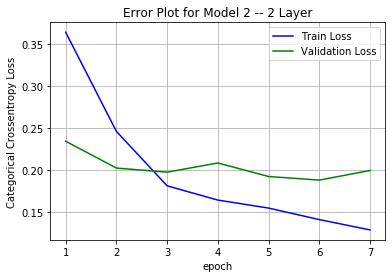

In [55]:
# Plotting the Loss Vs Epoch graph
fig, ax = plt.subplots(1,1)
x = list(range(1,7+1))
vy = history3_lstm_model2.history['val_loss']
ty = history3_lstm_model2.history['loss']
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss'); ax.set_title('Error Plot for Model 2 -- 2 Layer')
plt_dynamic(x,ty,vy,ax)

**MODEL 3 :** 

In [43]:
top_words = 5000
embedding_vector_length = 32
model_layer3 = Sequential()
model_layer3.add(Embedding(top_words+1, embedding_vector_length, input_length=max_review_length))
model_layer3.add(LSTM(200, return_sequences=True))
model_layer3.add(LSTM(150, return_sequences=True))
model_layer3.add(LSTM(100))
model_layer3.add(Dropout(0.5))
model_layer3.add(Dense(1, activation='sigmoid'))
model_layer3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',auc])
print(model_layer3.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 200)          186400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 150)          210600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dropout_1 (Dropout)

In [0]:
history4_lstm_model3 = model_layer3.fit(X_train, Y_1, nb_epoch=5, batch_size=64, validation_data=(X_test, Y_test), callbacks=[aucCal, earlyStop] )
# Final evaluation of the model
scores4 = model_layer3.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores4[1]*100))
print(scores4)
print("Loss : ", scores4[0])



Train on 70218 samples, validate on 17555 samples
Epoch 1/5
70218/70218 [==============================] - 3990s 57ms/step - loss: 0.2605 - acc: 0.8972 - auc: 0.8350 - val_loss: 0.2098 - val_acc: 0.9167 - val_auc: 0.9089
roc-auc: 0.9607 - roc-auc_val: 0.9469                                                                                                    
Epoch 2/5
70218/70218 [==============================] - 4052s 58ms/step - loss: 0.1883 - acc: 0.9271 - auc: 0.9247 - val_loss: 0.2179 - val_acc: 0.9151 - val_auc: 0.9322
roc-auc: 0.9673 - roc-auc_val: 0.9448                                                                                                    
Epoch 3/5
70218/70218 [==============================] - 3994s 57ms/step - loss: 0.1662 - acc: 0.9371 - auc: 0.9384 - val_loss: 0.2063 - val_acc: 0.9237 - val_auc: 0.9423
roc-auc: 0.9778 - roc-auc_val: 0.9514                                                                                                    
Epoch 4/5
70218/70218

The session is getting disconnected after 10.5 hours. Till then only the running of 5 epochs is completed. The evaluation is not run. I have tried it two times and both times the same result is got. I have kept both the results .

In [0]:
history4_lstm_model3 = model_layer3.fit(X_train, Y_1, nb_epoch=5, batch_size=64, validation_data=(X_test, Y_test), callbacks=[aucCal, earlyStop] )
# Final evaluation of the model
scores4 = model_layer3.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores4[1]*100))
print(scores4)
print("Loss : ", scores4[0])



Train on 70218 samples, validate on 17555 samples
Epoch 1/5
70218/70218 [==============================] - 3904s 56ms/step - loss: 0.2704 - acc: 0.8937 - auc: 0.8321 - val_loss: 0.2894 - val_acc: 0.8946 - val_auc: 0.8920
roc-auc: 0.9272 - roc-auc_val: 0.9116                                                                                                    
Epoch 2/5
70218/70218 [==============================] - 3826s 54ms/step - loss: 0.2187 - acc: 0.9145 - auc: 0.9046 - val_loss: 0.2220 - val_acc: 0.9107 - val_auc: 0.9133
roc-auc: 0.9619 - roc-auc_val: 0.9434                                                                                                    
Epoch 3/5
70218/70218 [==============================] - 3963s 56ms/step - loss: 0.1807 - acc: 0.9315 - auc: 0.9225 - val_loss: 0.1992 - val_acc: 0.9190 - val_auc: 0.9291
roc-auc: 0.9735 - roc-auc_val: 0.9508                                                                                                    
Epoch 4/5
70218/70218

In [0]:
print("Test AUC for Model 3 with 3 Layer : ", scores4[2])

In [0]:
# Plotting the Loss Vs Epoch graph
fig, ax = plt.subplots(1,1)
x = list(range(1,n_epoch+1))
vy = history4_lstm_model3.history['val_loss']
ty = history4_lstm_model3.history['loss']
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss'); ax.set_title('Error Plot for Model 3 -- 3 Layer')
plt_dynamic(x,ty,vy,ax)

**SUMMARY OF THE MODELS :**

In [13]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","AUC", "Validation Loss"]
x.add_row([ 1,0.9589, 0.1982])
x.add_row([ 2,0.9473,0.1995])
x.add_row([ 3,0.9460,0.1984])
print(x)


+-------+--------+-----------------+
| Model |  AUC   | Validation Loss |
+-------+--------+-----------------+
|   1   | 0.9589 |      0.1982     |
|   2   | 0.9473 |      0.1995     |
|   3   | 0.946  |      0.1984     |
+-------+--------+-----------------+
